In [123]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output

In [342]:
class Grid():
    
    '''
    Generates and operates the grid structure that the snake game will be playing in.
    
    This will be in a matrix:
    [ 0 0 0 0 ]
    [ 0 0 0 0 ]
    [ 0 0 0 0 ]
    [ 0 0 0 0 ]
    
    Wherein the starting position (0,0) is the upper left corner and the maximum position
    is at (max_x, max_y) at the lower right of the square.
    
    All non-zero elements will be considered as occupied, therefore the board will be 
    initiated with:
    [ 1 1 1 1 ]
    [ 1 0 0 1 ]
    [ 1 0 0 1 ]
    [ 1 1 1 1 ]
    wherein the 1s denote the borders of the board.
    '''
    
    def __init__(self, max_x, max_y, snake):
        
        '''
        Generates an empty square board with size (max_x, max_y). This is generated using a
        numpy matrix of 0s wherein a border of 1s is added all around the play space.
        '''
        # instantiate board
        self.width = max_x
        self.height = max_y
        self.board = np.zeros((self.width+2, self.height+2))
        self.board[0] = 1
        self.board[-1] = 1
        self.board[:,0] = 1
        self.board[:,-1] = 1
        
        # instantiate first food
        food_idx = np.random.choice(np.argsort(self.board.flatten())\
                                      [:(self.board < 1).sum()])
        row = food_idx // self.board.shape[0]
        col = food_idx - (self.board.shape[0] * row)
        self.board[row,col] = 2
        
        # instantiate snake board tracker
        self.snake_board = np.zeros((self.width+2, self.height+2))
        for i in snake.body:
            self.snake_board[i[0],i[1]] += 1
        self.snake_board[snake.head_coord[0], snake.head_coord[1]] += 1
        
    def step(self, snake):
        
        '''
        Plots the movement of the snake in the board
        '''
        
        self.snake_board = np.zeros((self.width+2, self.height+2))
        for i in snake.body:
            self.snake_board[i[0],i[1]] += 1
        self.snake_board[snake.head_coord[0], snake.head_coord[1]] += 1 
        
    def food(self):
        
        self.board[self.board==2] = 0 # need to reset the board first
        food_idx = np.random.choice(np.argsort(self.board.flatten())\
                                      [:(self.board < 1).sum()])
        row = food_idx // self.board.shape[0]
        col = food_idx - (self.board.shape[0] * row)
        self.board[row,col] = 2

In [343]:
class Snake():
    '''
    Generates a new Snake agent that can be used to play the snake game.
    
    For the snake actions:
    
    UP = 1
    DOWN = 2
    LEFT = 3
    RIGHT = 4
    
    '''
    
    UP = 1
    DOWN = 2
    LEFT = 3
    RIGHT = 4

    
    def __init__(self, starting_head_coord, length=3):
        self.direction = 1
        self.head_coord = np.asarray(starting_head_coord)
        self.body = deque()
        for i in range(length-1, 0, -1):
            self.body.append((self.head_coord - np.array([0,i])).astype(int))
        self.length = length
        
    def step(self, action):
    
        self.body.append(self.head_coord) #we expand the body with the latest head

        if action == 1:
            self.head_coord = self.head_coord + np.array([-1,0])
        elif action == 2:
            self.head_coord = self.head_coord + np.array([1,0])
        elif action == 3:
            self.head_coord = self.head_coord + np.array([0,-1])
        elif action == 4:
            self.head_coord = self.head_coord + np.array([0,1])

        self.direction = action
        
    def expand(self, food=False):
        
        if food:
            self.length += 1 #expand the total length of the body if we get food

        elif len(self.body) > self.length:
            self.body.popleft() #if you didn't get food, you remove the last part of the body

In [431]:
class PlayGame():
    
    '''
    Defines the wrapper function that manipulates the Snake and Grid classes to play a 
    game of snake. This will be used for the gym_env wrapper.
    '''

    def __init__(self, width=40, height=40, snake_length=3):
        self.snake = Snake([width//2, height//2], length=snake_length)
        self.grid = Grid(width, height, self.snake)
        
        
    def step(self, action):
        state = (self.grid.board + self.grid.snake_board)
        self.snake.step(action)
        self.grid.step(self.snake)
        
        food = False
        
        if ((self.grid.board + self.grid.snake_board)==2).sum() or \
            (self.grid.snake_board==2).sum():
            reward = -1 #this means that you're dead, son
            
        elif ((self.grid.board + self.grid.snake_board)==3).sum():
            reward = 1 #you got the eats, son
            food = True
        
        else:
            reward = 0 #you just moved but didn't die OR get the food
            food = False
        
        if not food:
            self.grid.snake_board[self.snake.body[0][0], self.snake.body[0][1]] = 0
            
        self.snake.expand(food) #expand or contract the snake depending on food
        
        if food:
            self.grid.food()
        
        next_state = (self.grid.board + self.grid.snake_board)
        
        return state, action, next_state, reward
    
    def render(self):
        plt.cla
        plt.imshow((self.grid.board + self.grid.snake_board))
        plt.axis('off')
        plt.show()

In [442]:
game = PlayGame()

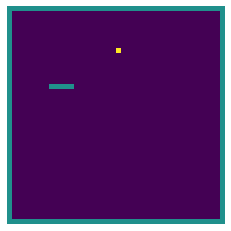

In [ ]:
for i in range(100000):
    game.render()
    move = input('action?')
    game.step(int(move))
    clear_output()
    